In [5]:
import jax
import pennylane as qml
from pennylane import numpy as np
from pennylane import draw
from pennylane import grad
from pennylane.optimize import AdamOptimizer
from pennylane.fourier import circuit_spectrum
import matplotlib
import matplotlib.pyplot as plt
import gymnasium as gym
from collections import deque
import random

In [55]:
@qml.qnode(dev)
def actor_qnode(n_qubits, state_input, theta, theta_par):
    # Apply Hadamard
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
    
    # RX with state-dependent angle
    for i in range(n_qubits):
        qml.RX(state_input[i], wires=i)
    
    # Entanglement (CZ between neighbours)
    for i in range(n_qubits - 1):
        qml.CZ(wires=[i, i+1])
    
    # RY with trainable parameter
    for i in range(0, n_qubits):
        qml.RY(theta_par[i], wires=i)
    
    # Measurement
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [56]:
@qml.qnode(dev)
def critic_qnode(n_qubits, critic_input, theta, theta_par):
    # Build same ansatz as above, with critic_input
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        qml.RX(critic_input[i], wires=i)

    for i in range(n_qubits - 1):
        qml.CZ(wires=[i, i+1])

    for i in range(0, n_qubits):
        qml.RY(theta_par[i], wires=i)

    # Q-value output (e.g., Z₀ expectation)
    return [qml.expval(qml.PauliZ(0)) for i in range(n_qubits)]

In [2]:
def make_critic_qnode(n_qubits):
    dev = qml.device("default.qubit", wires=n_qubits)
    
    @qml.qnode(dev)
    def critic_qnode(critic_input, theta, theta_par):
        # Build same ansatz as above, with critic_input
        for i in range(n_qubits):
            qml.Hadamard(wires=i)
            qml.RX(critic_input[i], wires=i)
    
        for i in range(n_qubits - 1):
            qml.CZ(wires=[i, i+1])
    
        for i in range(0, n_qubits):
            qml.RY(theta_par[i], wires=i)
    
        # Q-value output (e.g., Z₀ expectation)
        #return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
        return qml.expval(qml.PauliZ(i))
    return critic_qnode

def make_actor_qnode(n_qubits):
    dev = qml.device("default.qubit", wires=n_qubits)
    
    @qml.qnode(dev)
    def actor_qnode(state_input, theta, theta_par):
        # Apply Hadamard
        for i in range(n_qubits):
            qml.Hadamard(wires=i)
        
        # RX with state-dependent angle
        for i in range(n_qubits):
            qml.RX(state_input[i], wires=i)
        
        # Entanglement (CZ between neighbours)
        for i in range(n_qubits - 1):
            qml.CZ(wires=[i, i+1])
        
        # RY with trainable parameter
        for i in range(0, n_qubits):
            qml.RY(theta_par[i], wires=i)
        
        # Measurement
        #return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
        return qml.expval(qml.PauliZ(i))
    return actor_qnode

In [3]:
# TODO: PROPERLY PORT THE QISKIT VERSION TO PENNYLANE
# TODO: IMPORT THE UAV LQDRL GYM ENVIRONMENT TO GET & UPDATE THESE VALUES AFTER EVERY LAYER
m_layers = 3
E_rem = 500e03
num_gus = 4
u = []
uav_pos = [0, 0, 0]
uav_v_max = 30
zeta_v = 1
uav_v = zeta_v * uav_v_max
noma_g = [1, 2, 3]
pwr_alloc = 1
action_vec = []

action_vec.append(uav_v)
for k in range(len(noma_g)):
    action_vec.append(noma_g[k])
action_vec.append(pwr_alloc)

actor_inp_vec = []
crit_inp_vec = []

for i in range(len(uav_pos)):
    actor_inp_vec.append(uav_pos[i])
actor_inp_vec.append(E_rem)
for j in range(2*num_gus):
    u.append(j)
    actor_inp_vec.append(u[j])

full_input = np.concatenate([actor_inp_vec, action_vec])

n_qubits = len(actor_inp_vec)
print(n_qubits) 
n_crit_qubits = len(full_input)
print(n_crit_qubits)

theta = np.zeros(n_qubits, requires_grad=True)
theta_par = np.random.randn(n_qubits, requires_grad=True)

crit_theta = np.zeros(n_crit_qubits, requires_grad=True)
crit_theta_par = np.random.randn(n_crit_qubits, requires_grad=True)

critic_qnode = make_critic_qnode(n_crit_qubits)
#q_val = critic_qnode(n_crit_qubits, full_input, crit_theta, crit_theta_par)
q_val = critic_qnode(full_input, crit_theta, crit_theta_par)

actor_qnode = make_actor_qnode(n_qubits)
#q_vals = actor_qnode(n_qubits, actor_inp_vec, theta, theta_par)
q_vals = actor_qnode(actor_inp_vec, theta, theta_par)

'''
# Forward pass
q_vals = actor_qnode(n_qubits, actor_inp_vec, theta, theta_par)
q_val = critic_qnode(n_crit_qubits, full_input, crit_theta, crit_theta_par)
'''

12
17


'\n# Forward pass\nq_vals = actor_qnode(n_qubits, actor_inp_vec, theta, theta_par)\nq_val = critic_qnode(n_crit_qubits, full_input, crit_theta, crit_theta_par)\n'

(<Figure size 1700x1300 with 1 Axes>, <Axes: >)

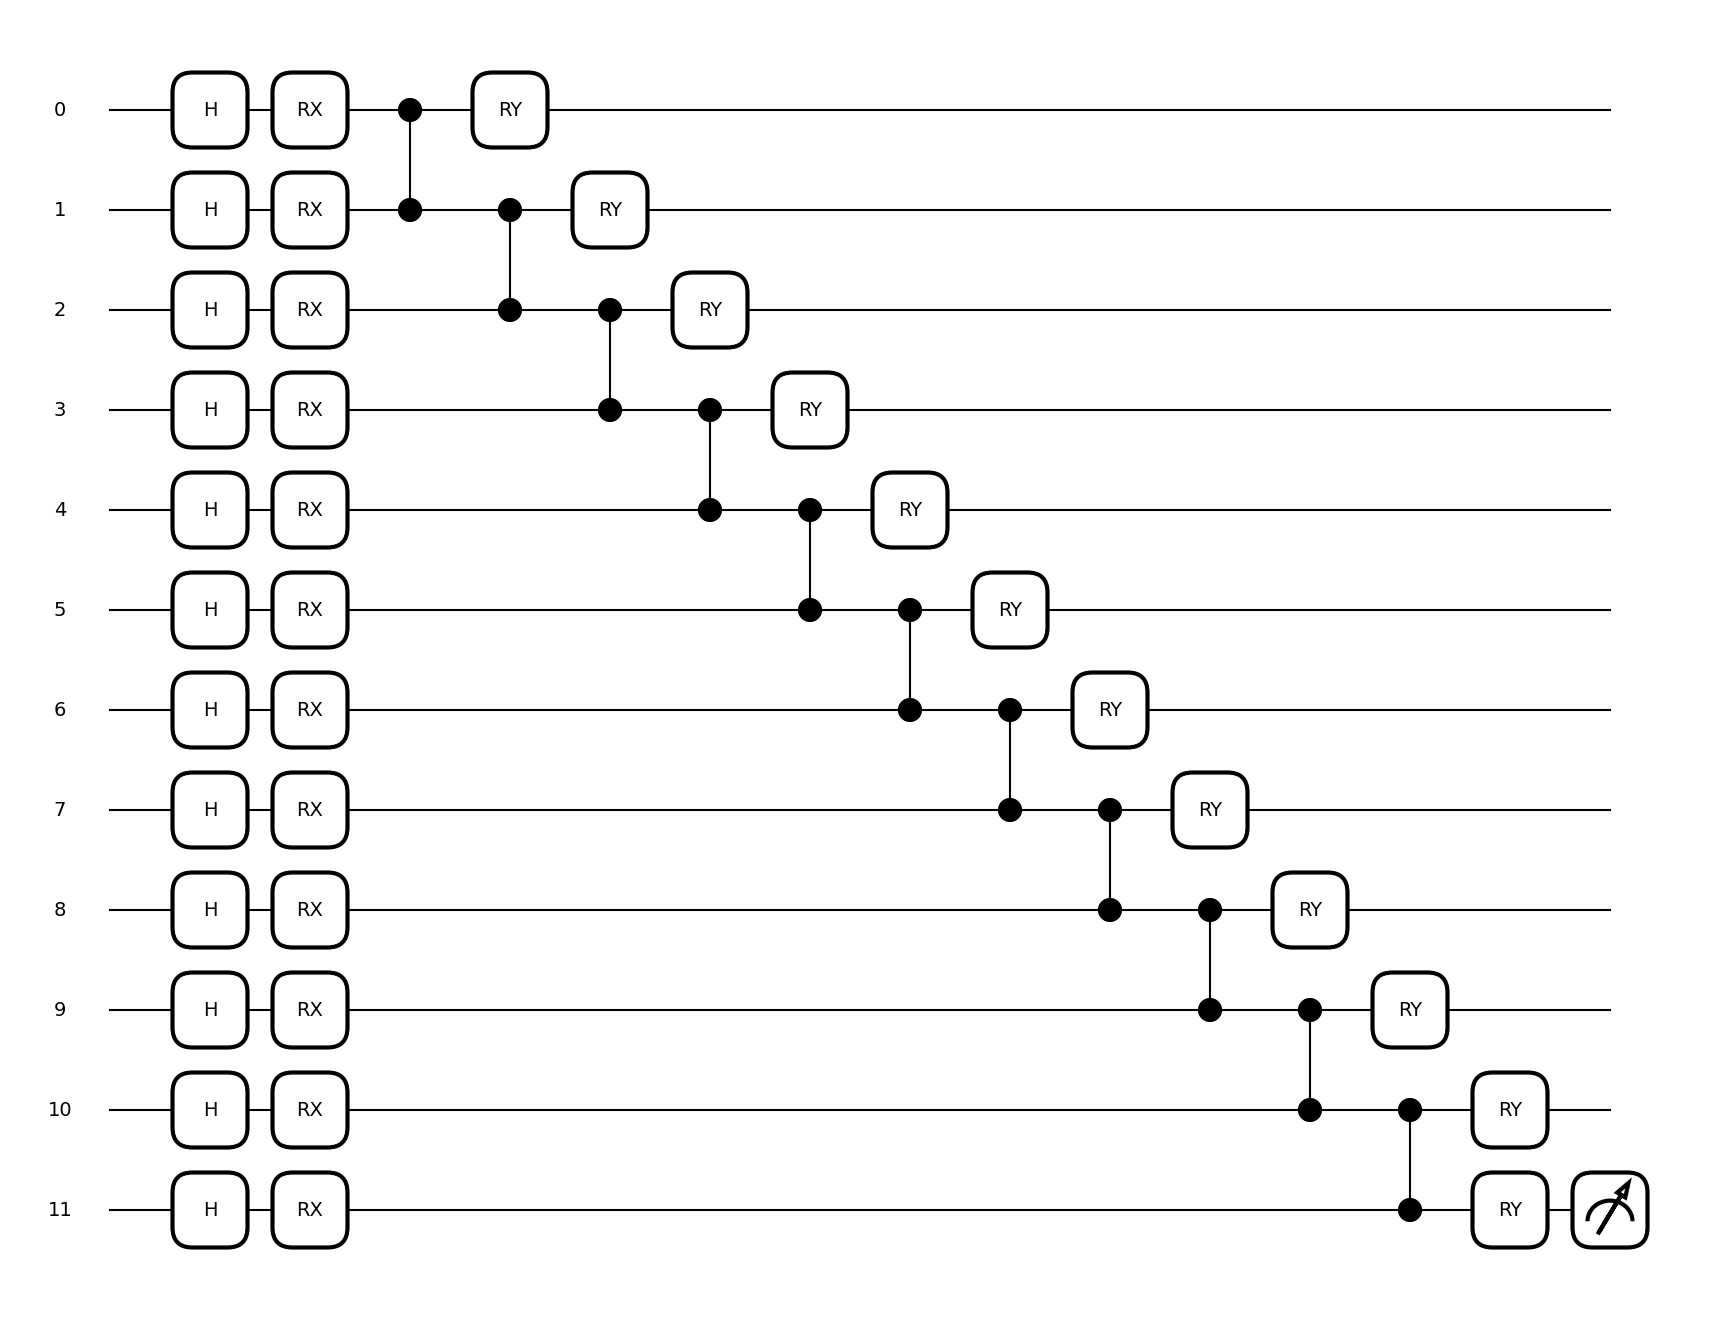

In [5]:
qml.draw_mpl(actor_qnode)(np.ones(n_qubits), np.ones(n_qubits), np.ones(n_qubits))
#qml.draw(actor_qnode)(n_qubits, np.ones(n_qubits), np.ones(n_qubits), np.ones(n_qubits))

(<Figure size 2200x1800 with 1 Axes>, <Axes: >)

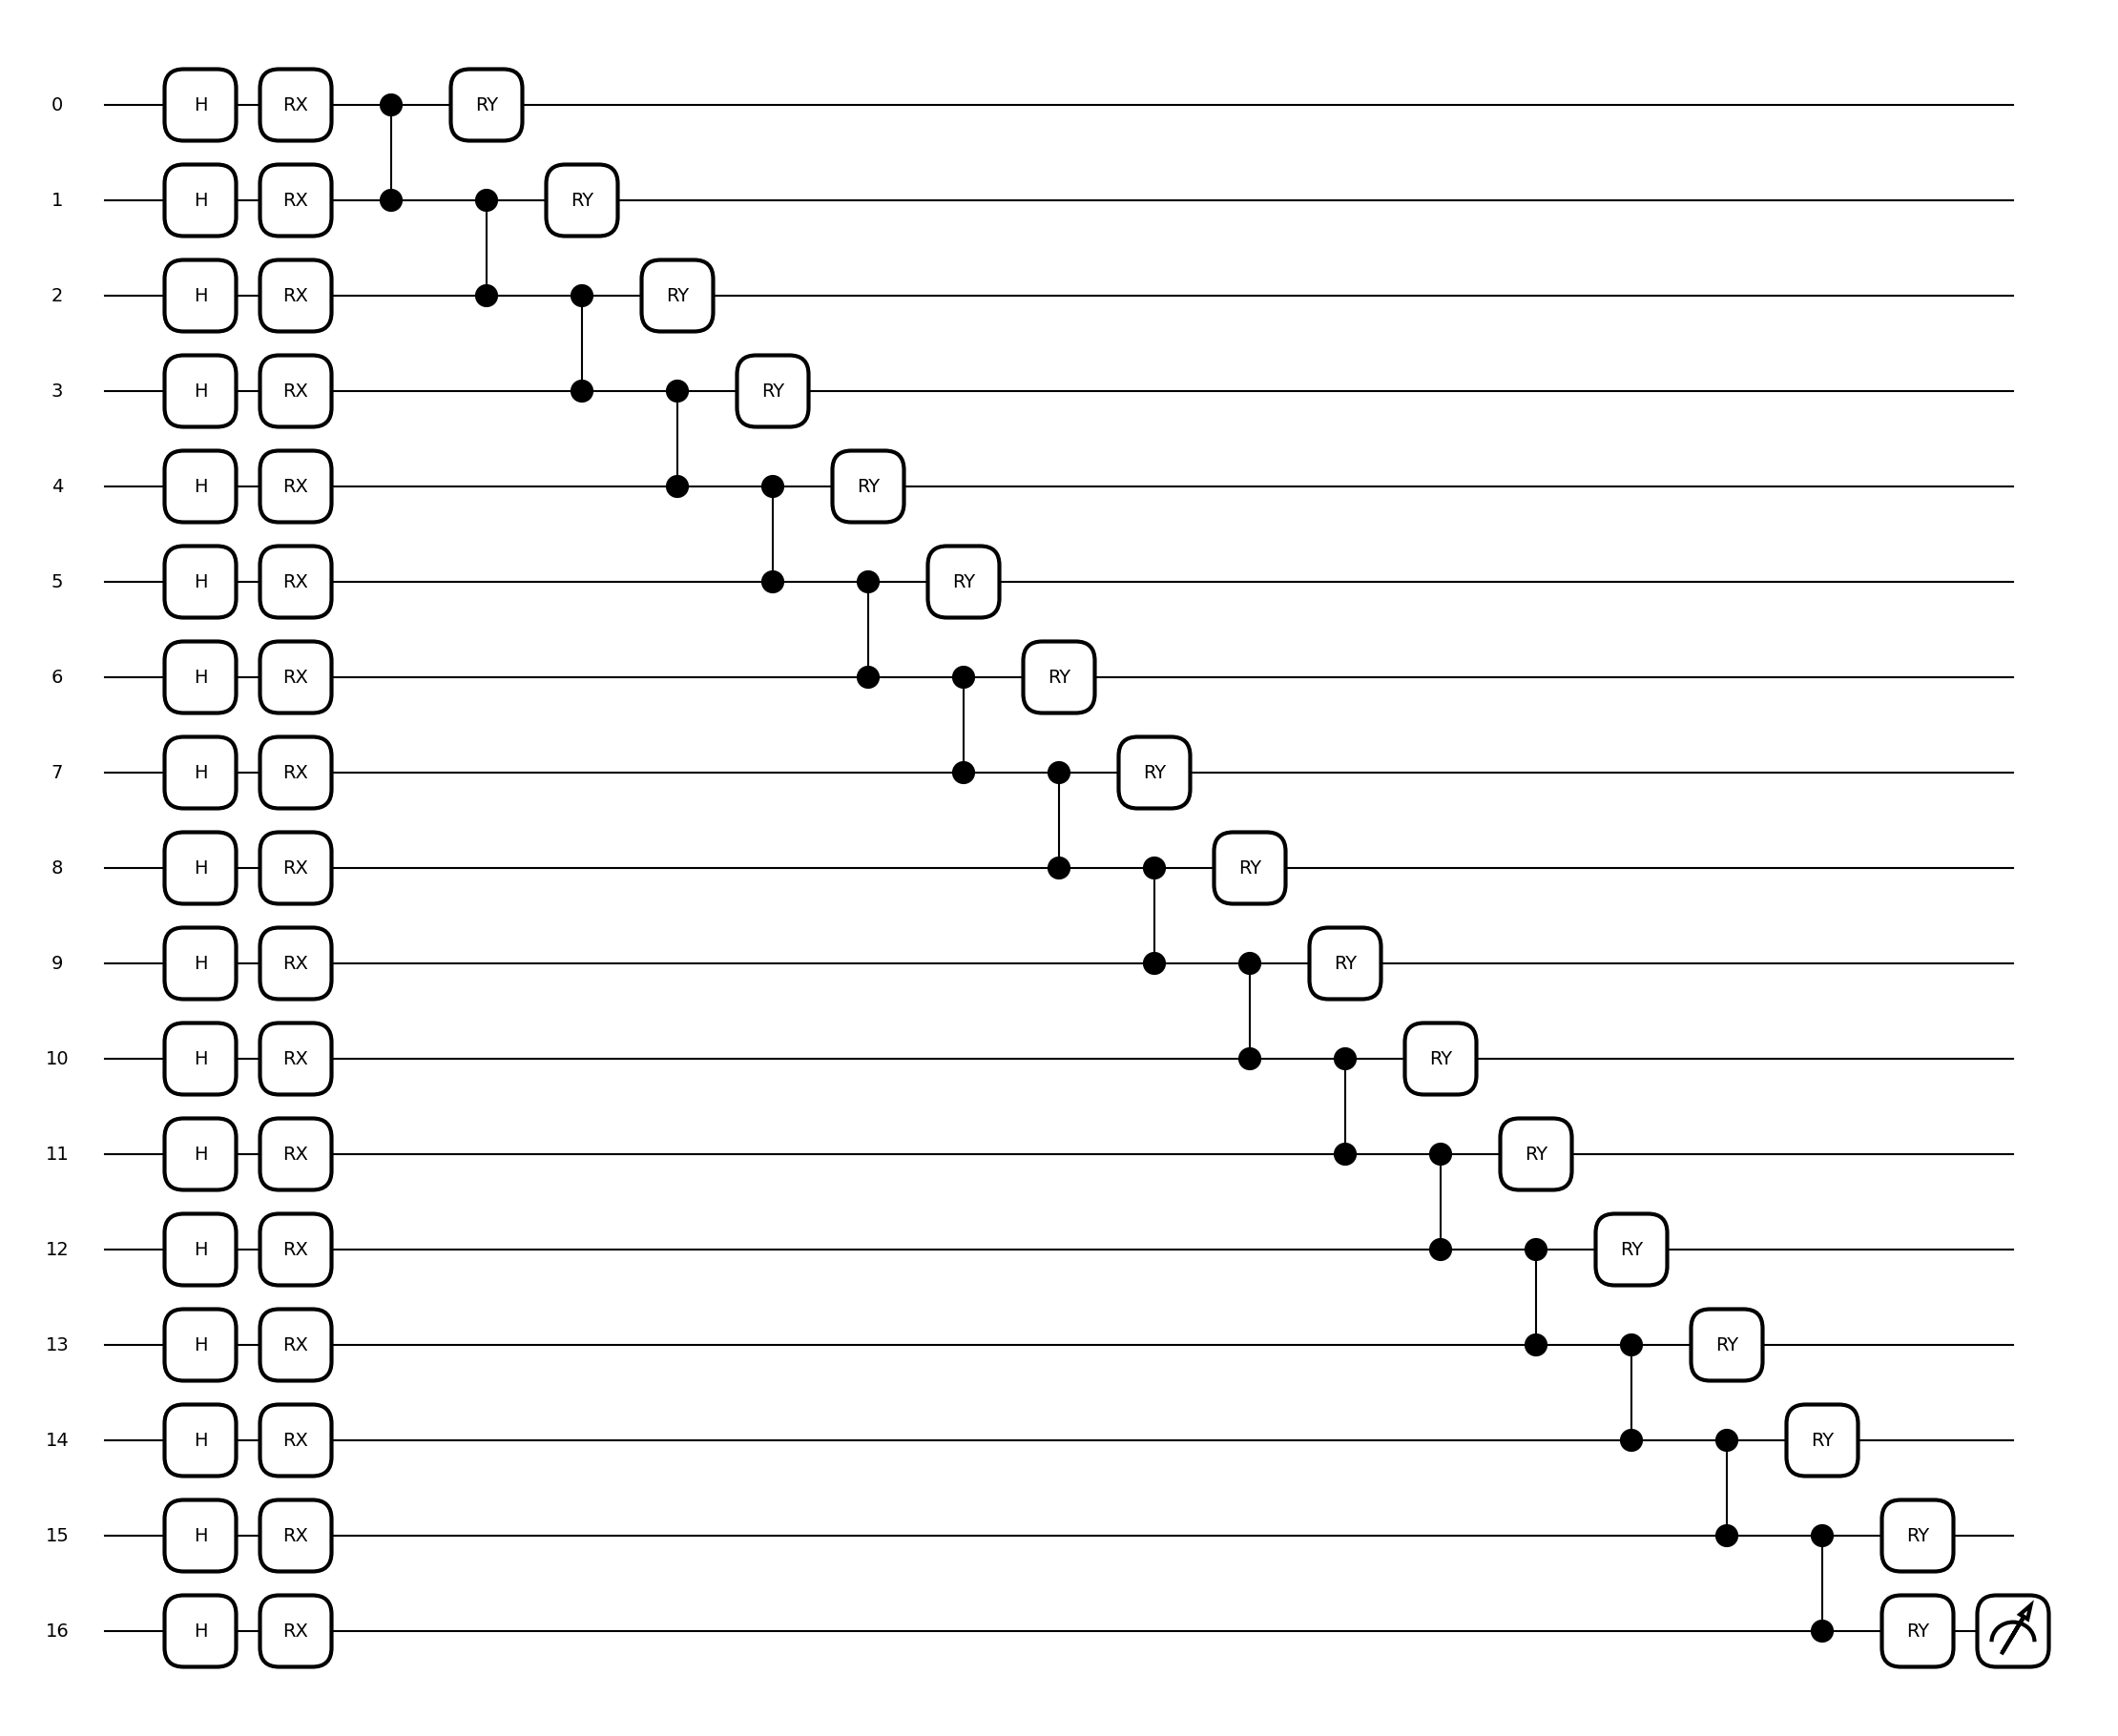

In [6]:
qml.draw_mpl(critic_qnode)(np.ones(n_crit_qubits), np.ones(n_crit_qubits), np.ones(n_crit_qubits))

In [4]:
actor_grad_fn = qml.grad(actor_qnode, argnum=2)
grad_vals = actor_grad_fn(actor_inp_vec, theta, theta_par)
print(grad_vals)

[-7.60569785e-19 -3.11482160e-18 -6.97557207e-19 -8.58990915e-19
 -9.83860095e-19 -8.48520347e-18 -4.62225150e-19 -1.86031729e-18
  7.62954659e-19  1.47986126e-18  1.53169624e-16  8.68379454e-16]


In [5]:
critic_grad_fn = qml.grad(critic_qnode, argnum=2)
grad_vals = critic_grad_fn(full_input, crit_theta, crit_theta_par)
print(grad_vals)

[ 1.32477750e-19  4.55907210e-19 -5.39133518e-19  3.60246274e-19
  2.02301562e-18 -1.32428499e-20 -1.29978734e-18 -6.11851547e-19
 -4.35873108e-19 -9.05842083e-19 -5.73309512e-19  9.58504911e-19
 -2.48842931e-19  1.23305421e-18  4.88507856e-19  4.85252118e-18
  2.65650068e-18]


In [6]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)
for _ in range(10):
    theta_par, loss = opt.step_and_cost(lambda tp: -critic_qnode(full_input, crit_theta, tp), crit_theta_par)
    print("Loss:", loss)

Loss: 5.10702591327572e-15
Loss: 5.10702591327572e-15
Loss: 5.10702591327572e-15
Loss: 5.10702591327572e-15
Loss: 5.10702591327572e-15
Loss: 5.10702591327572e-15
Loss: 5.10702591327572e-15
Loss: 5.10702591327572e-15
Loss: 5.10702591327572e-15
Loss: 5.10702591327572e-15


In [ ]:
# TODO: Implement updating the theta parameter for the RY gates 
# TODO: Implement updating the x input data vector for the RX gates based on the values stored in the Memory Experience Relay
#num_eps = 10
#for i in range(num_eps):
    

In [ ]:
# Function to take the rewards and updated observation state space and output s' (new state)
# Returns the input current observation state, the action taken by the agent, the reward given by the action and the updated state
# State s should be passed to the actor ansatz
# State s and action a should be passed to the critic ansatz
def mem_exp_replay_buffer(state, action, rewards):
    new_state = state

In [2]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

In [20]:
%load_ext autoreload
%autoreload 2
from uav_lqdrl_env import UAV_LQDRL_Environment
from quantum_models import QuantumActor, QuantumCritic
from pennylane.optimize import AdamOptimizer

# Setup
env = UAV_LQDRL_Environment()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

actor = QuantumActor(n_qubits=state_dim, m_layers=3)
critic = QuantumCritic(n_qubits=state_dim + action_dim, m_layers=3)
buffer = ReplayBuffer()

actor_opt = AdamOptimizer(stepsize=0.01)
critic_opt = AdamOptimizer(stepsize=0.01)

episodes = 30
batch_size = 32
gamma = 0.99

tot_reward_arr = []
reward_arr = []

for ep in range(episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        state_tensor = np.array(state, requires_grad=False)

        # === ACTOR ===
        action = actor(state_tensor)
        action = np.clip(np.array(action), -1, 1)

        # === STEP ===
        next_state, reward, done, _, _ = env.step(action)
        buffer.push(state, action, reward, next_state, done)

        total_reward += reward
        state = next_state

        # === TRAIN ===
        if len(buffer) >= batch_size:
            batch = buffer.sample(batch_size)
            states, actions, rewards, next_states, dones = map(np.array, zip(*batch))

            # === CRITIC UPDATE ===
            def critic_loss(theta):
                critic.update_params(theta)
                loss = 0
                for s, a, r, ns, d in zip(states, actions, rewards, next_states, dones):
                    sa = np.concatenate([s, a])
                    q_val = critic(sa)
                    na = actor(ns)
                    nsa = np.concatenate([ns, na])
                    target = r + gamma * critic(nsa) * (1 - d)
                    loss += (q_val - target)**2
                return loss / batch_size

            critic.theta, _ = critic_opt.step_and_cost(critic_loss, critic.theta)

            # === ACTOR UPDATE ===
            def actor_loss(theta):
                actor.update_params(theta)
                loss = 0
                for s in states:
                    a = actor(s)
                    sa = np.concatenate([s, a])
                    q_val = critic(sa)
                    loss -= q_val
                return loss / batch_size

            actor.theta, _ = actor_opt.step_and_cost(actor_loss, actor.theta)

    print(f"Episode {ep} | Total reward: {total_reward:.2f}")
    tot_reward_arr.append(total_reward)
    reward_arr.append(reward)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Episode 0 | Total reward: 21.32
Episode 1 | Total reward: 34.65
Episode 2 | Total reward: 13.98
Episode 3 | Total reward: 25.37
Episode 4 | Total reward: 14.18
Episode 5 | Total reward: 22.91
Episode 6 | Total reward: 15.44
Episode 7 | Total reward: 34.28
Episode 8 | Total reward: 20.21
Episode 9 | Total reward: 7.13
Episode 10 | Total reward: 15.68
Episode 11 | Total reward: 21.80
Episode 12 | Total reward: 15.51
Episode 13 | Total reward: 31.50
Episode 14 | Total reward: 11.85
Episode 15 | Total reward: 34.31
Episode 16 | Total reward: 27.34
Episode 17 | Total reward: -0.34
Episode 18 | Total reward: 20.95
Episode 19 | Total reward: 33.65
Episode 20 | Total reward: 8.29
Episode 21 | Total reward: 24.17
Episode 22 | Total reward: 34.90
Episode 23 | Total reward: 14.51
Episode 24 | Total reward: 21.15
Episode 25 | Total reward: 20.73
Episode 26 | Total reward: 0.77
Episode 27 | Total reward: 18.68
E

(<Figure size 2500x1300 with 1 Axes>, <Axes: >)

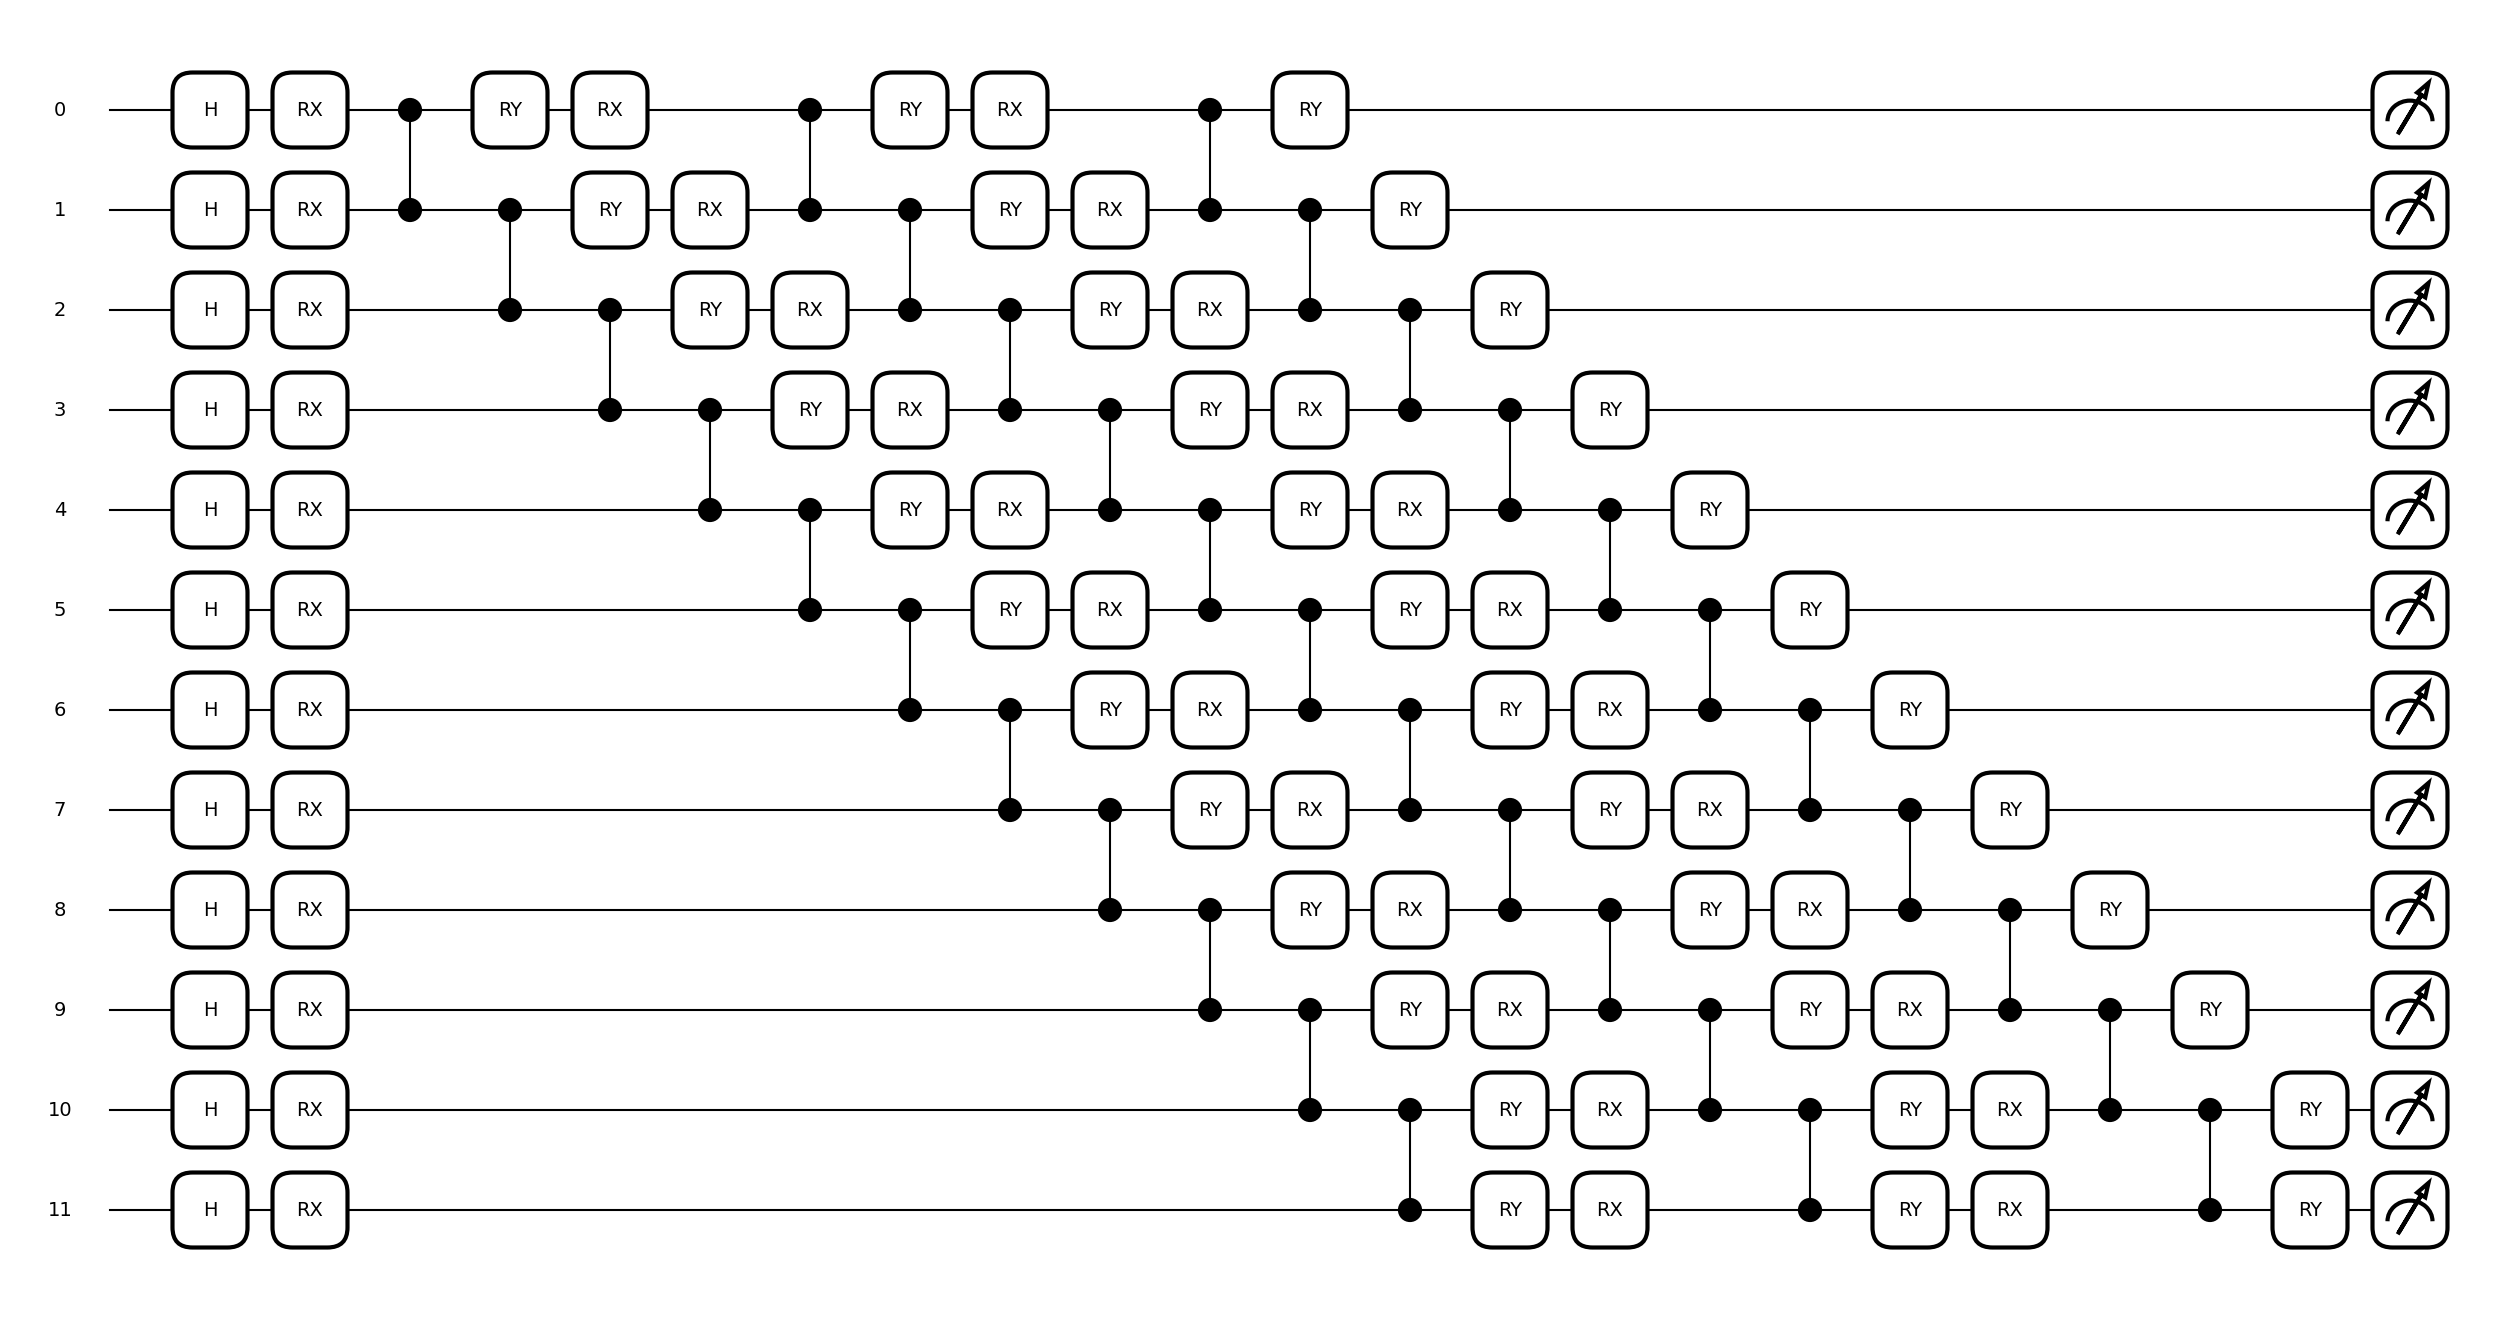

In [21]:
actor.latex(state_tensor)

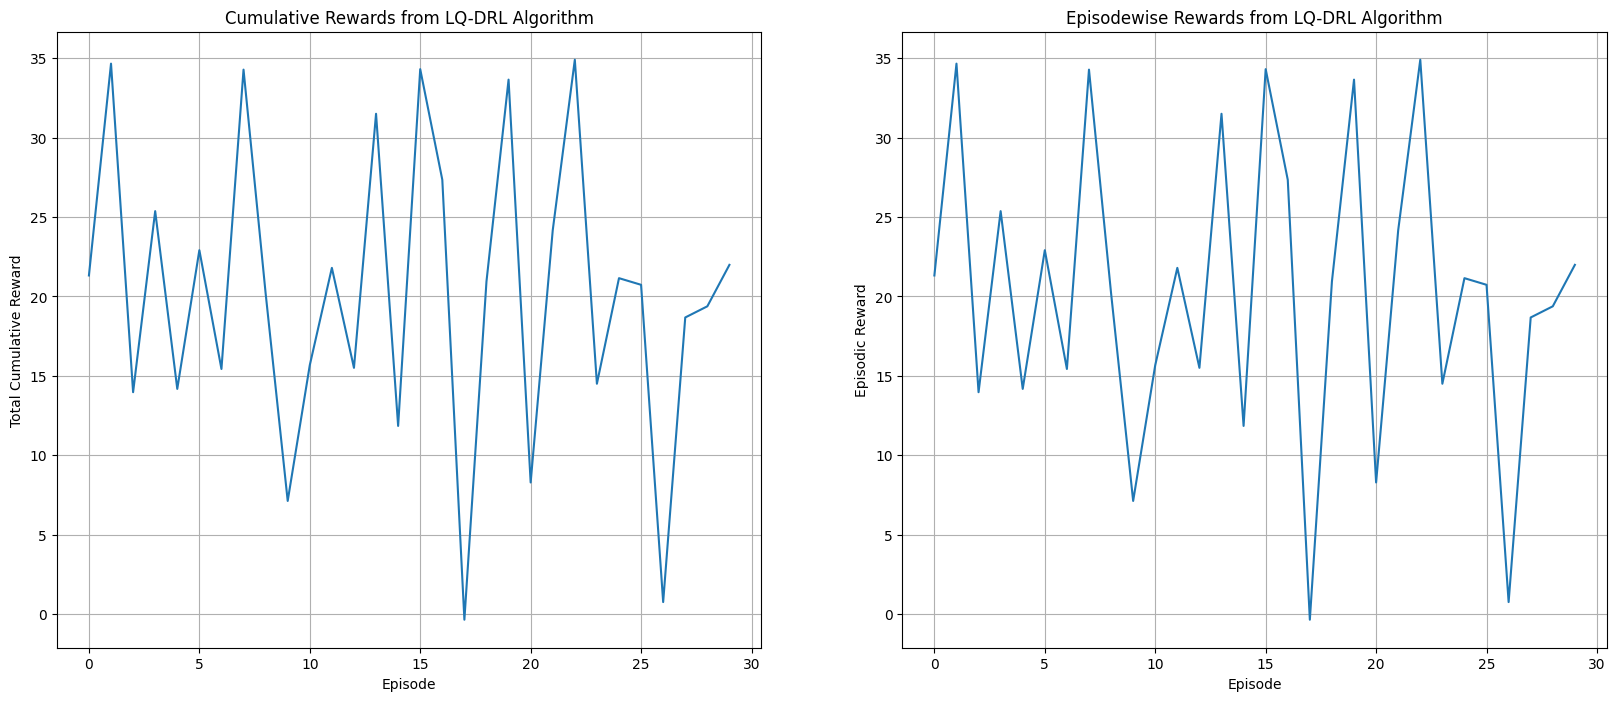

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
eps_arr = np.arange(0, episodes, 1)
ax[0].plot(eps_arr, tot_reward_arr)
ax[0].set_xlabel('Episode')
ax[0].set_ylabel('Total Cumulative Reward')
ax[0].grid()
ax[0].set_title('Cumulative Rewards from LQ-DRL Algorithm')

ax[1].plot(eps_arr, reward_arr)
ax[1].set_xlabel('Episode')
ax[1].set_ylabel('Episodic Reward')
ax[1].grid()
ax[1].set_title('Episodewise Rewards from LQ-DRL Algorithm')

plt.show()

In [10]:
%load_ext autoreload
%autoreload 2
from uav_lqdrl_env import UAV_LQDRL_Environment
from quantum_models import QuantumActor, QuantumCritic

env = UAV_LQDRL_Environment()
obs, _ = env.reset()

num_episodes = 1

# Setup actor and critic
n_qubits_actor = len(obs)
print(n_qubits_actor) 
m_layers = 3
actor = QuantumActor(n_qubits=n_qubits_actor, m_layers=m_layers)

# Placeholder for critic input: obs + action (can be dynamic)
n_qubits_critic = n_qubits_actor + 5
print(n_qubits_critic) 
critic = QuantumCritic(n_qubits=n_qubits_critic, m_layers=m_layers)

# TODO: Implement each episode each containing T timesteps
# Plot energy efficiency for {t1, t2, ..., T} for each episode
# Try this with M layers where m=1 up to M=3 (can experiment with more layers later)
for episode in range(num_episodes):
    obs, _ = env.reset()
    done = False
    while not done:
        action_vec = actor(obs)
        # Map output to environment action space [-1, 1]
        action = np.tanh(action_vec[:5])
        next_obs, reward, done, _, _ = env.step(action)
        q_val = critic(np.concatenate([obs, action]))

        #actor_grad_fn = qml.grad(actor_qnode, argnum=2)
        actor_grad_fn = qml.grad(actor, argnum=2)
        #grad_vals = actor_grad_fn(n_qubits, m_layers)
        grad_vals = actor_grad_fn(actor_inp_vec, theta, theta_par)

        #critic_grad_fn = qml.grad(critic_qnode, argnum=2)
        
        critic_grad_fn = qml.grad(critic, argnum=2)
        crit_grad_vals = critic_grad_fn(crit_inp_vec, crit_theta, crit_theta_par)

        '''
        TODO: INCORPORATE & IMPLEMENT THIS FEATURE INTO THE TRAINING LOOP
        opt = AdamOptimizer(stepsize=0.01)

        # During training:
        grads = qml.grad(loss_fn)(theta)  # or use multiple params
        theta = opt.step(loss_fn, theta)
        '''

        # TODO: Apply gradient updates, use replay buffer, etc.

        obs = next_obs


print("All good so far")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
12
17


IndexError: tuple index out of range

In [ ]:
for episode in range(num_episodes): 
    obs, _ = env.reset()
    done = False
    while not done:
        action_vec = actor(obs)
        # Map output to environment action space [-1, 1]
        action = np.tanh(action_vec[:5])
        next_obs, reward, done, _, _ = env.step(action)
        q_val = critic(np.concatenate([obs, action]))

        actor_grad_fn = qml.grad(actor_qnode, argnum=2)
        grad_vals = actor_grad_fn(actor_inp_vec, theta, theta_par)

        critic_grad_fn = qml.grad(critic_qnode, argnum=2)
        crit_grad_vals = critic_grad_fn(crit_inp_vec, crit_theta, crit_theta_par)
        
        # Sample batch
        states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
        
        # Compute targets using Critic
        target_q_vals = critic(next_states, ...)  # QuantumCritic forward pass
        
        # Compute loss (e.g., MSE)
        loss = mse(current_q_vals, target_q_vals)
        
        # Backprop through the critic QNode
        grads = qml.grad(loss_fn)(critic.theta)
        critic.theta = opt.step(loss_fn, critic.theta)


In [38]:
print(np.tanh(np.pi))

0.19925441524414997


In [18]:
drawer = qml.draw_mpl(actor.qnode)
print(drawer(np.random.randn(n_qubits_actor), actor.theta))

NameError: name 'n_qubits_actor' is not defined

(<Figure size 2800x1800 with 1 Axes>, <Axes: >)


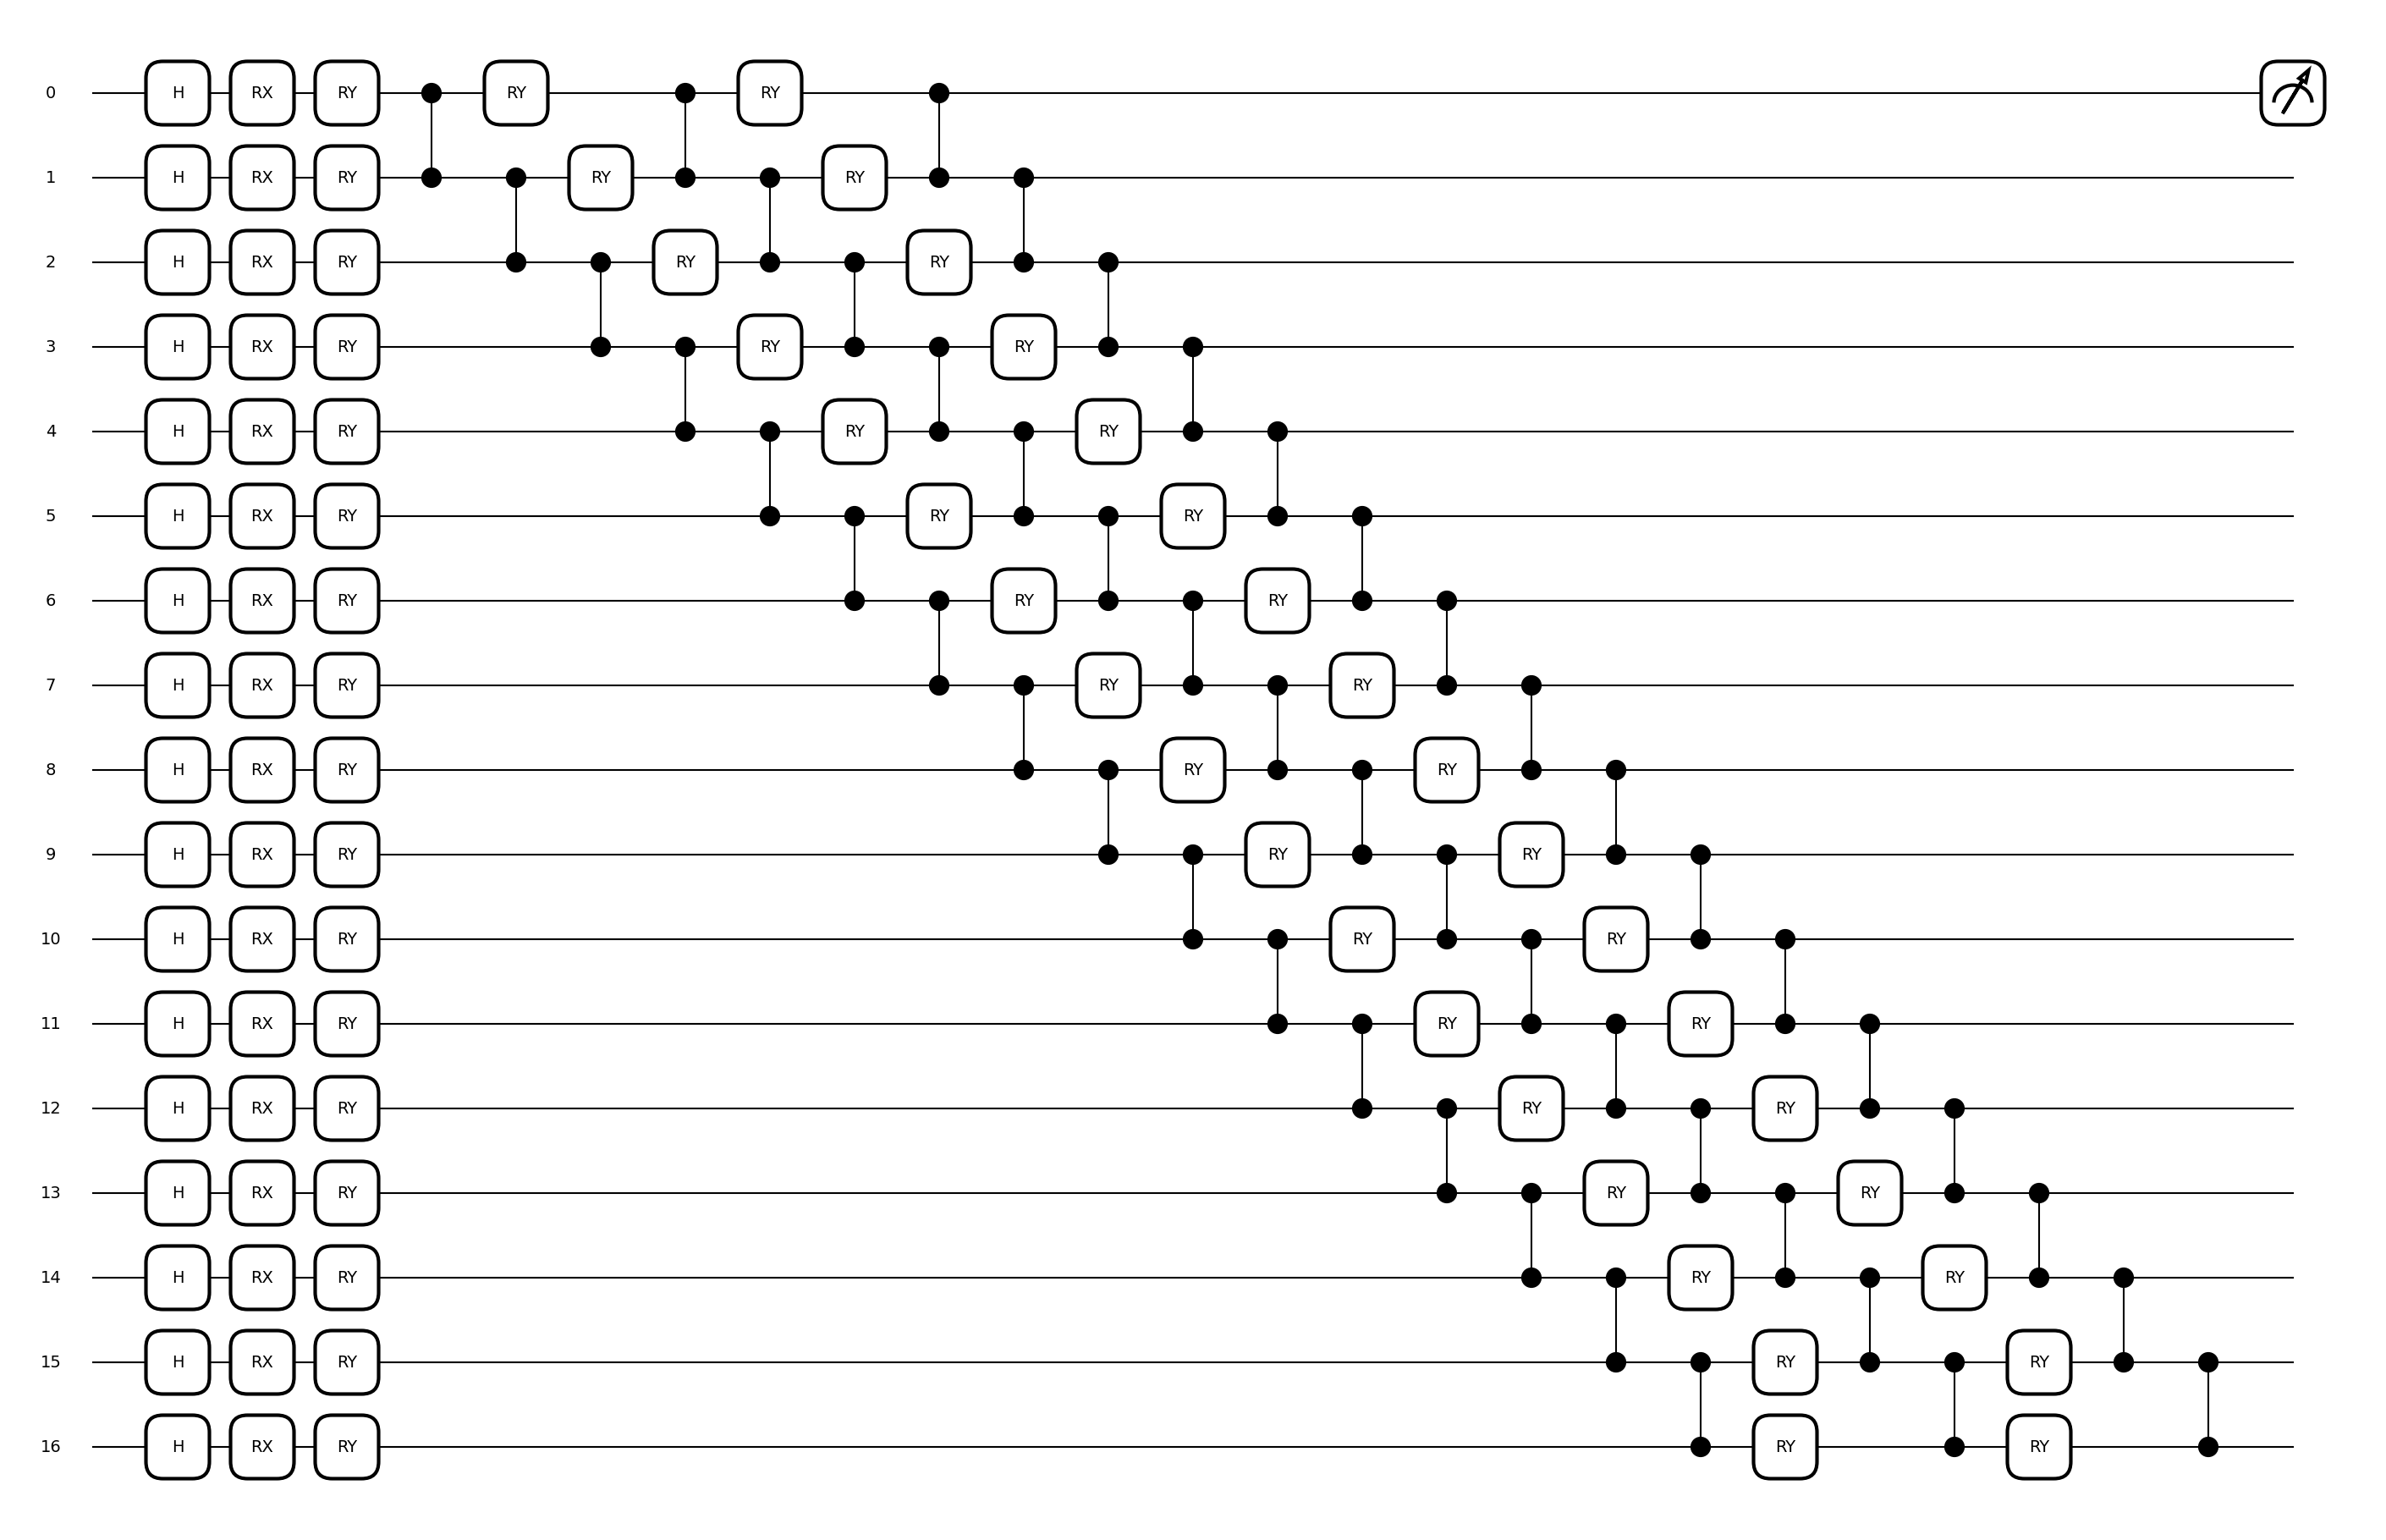

In [46]:
qml.drawer.use_style("black_white") 
drawer = qml.draw_mpl(critic.qnode)
print(drawer(np.random.randn(n_qubits_critic), critic.theta))